Оператор связи хочет бороться с оттоком клиентов. Нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

In [1]:
!pip -q install shap
!pip -q install phik

In [2]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap 
import torch
import torch.nn as nn
import itertools
import phik

from math import ceil

from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder 
from sklearn.preprocessing import  StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [3]:
RANDOM_STATE = 130423

# 1. Загрузка данных

In [4]:
db_config = {
'user': 'praktikum_student',# имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'db': 'data-science-final'# название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT table_name, column_name
FROM INFORMATION_SCHEMA.COLUMNS 
WHERE table_schema = 'telecom'
'''
super_table = pd.read_sql_query(query, con=engine) 

In [6]:
super_table

,table_name,column_name
0,personal,customerID
1,phone,c1
2,internet,c8
3,personal,Partner
4,contract,BeginDate
5,internet,c6
6,personal,SeniorCitizen
7,internet,c1
8,contract,PaperlessBilling
9,internet,c4


In [7]:
query = '''
SELECT pg_size_pretty(pg_total_relation_size('telecom.contract'))
'''
pd.read_sql_query(query, con=engine) 

,pg_size_pretty
0,720 kB


In [8]:
query = '''
SELECT *
FROM telecom.contract
'''

contract = pd.read_sql_query(query, con=engine) 
contract.columns = contract.columns.str.lower()

In [9]:
query = '''
SELECT pg_size_pretty(pg_total_relation_size('telecom.personal'))
'''
pd.read_sql_query(query, con=engine) 

,pg_size_pretty
0,448 kB


In [10]:
query = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(query, con=engine) 
personal.columns = personal.columns.str.lower()

In [11]:
query = '''
SELECT pg_size_pretty(pg_total_relation_size('telecom.internet'))
'''
pd.read_sql_query(query, con=engine) 

,pg_size_pretty
0,432 kB


In [12]:
query = '''
SELECT *
FROM telecom.internet
'''
internet = pd.read_sql_query(query, con=engine) 
internet.columns = internet.iloc[0].str.lower() #используем первую строку в качестве заголовков
internet = internet[1:].reset_index(drop=True)

In [13]:
query = '''
SELECT pg_size_pretty(pg_total_relation_size('telecom.phone'))
'''
pd.read_sql_query(query, con=engine) 

,pg_size_pretty
0,312 kB


In [14]:
query = '''
SELECT *
FROM telecom.phone
'''
phone = pd.read_sql_query(query, con=engine) 
phone.columns = phone.iloc[0].str.lower()
phone = phone[1:].reset_index(drop=True)

In [15]:
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данные загружены без ошибок

# 2. Анализ данных

## 2.1 Contract

In [16]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


таблица содержит информацию о договорах.
1. customerID — ID абонента;
2. BeginDate — дата начала действия договора;
3. EndDate — дата окончания действия договора;
4. Type — тип оплаты: раз в год-два или ежемесячно;
5. PaperlessBilling — электронный расчётный лист;
6. PaymentMethod — тип платежа;
7. MonthlyCharges — расходы за месяц;
8. TotalCharges — общие расходы абонента.

In [17]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           1869 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Все данные прописаны строкой. Нужно будет перевести даты и числа в соответствующий формат.

так же есть пропуски в дате завершения договора, очевидно, для тех, кто договор не прервал на дату получения данных. И 10 пропусков в общих расходах.

In [18]:
contract['begindate'] = pd.to_datetime(contract['begindate'], format='%Y-%m-%d')
contract['enddate'] = pd.to_datetime(contract['enddate'], format='%Y-%m-%d', errors='coerce')

In [19]:
contract['monthlycharges'] = contract['monthlycharges'].apply(pd.to_numeric, errors='coerce')
contract['totalcharges'] = contract['totalcharges'].apply(pd.to_numeric, errors='coerce')

In [20]:
contract.describe()

,monthlycharges,totalcharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


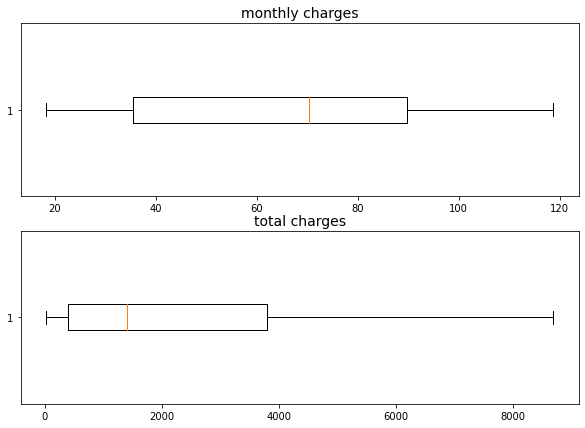

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].boxplot(contract['monthlycharges'], vert=False)
ax[0].set_title('monthly charges', fontsize=14)
ax[1].boxplot(contract['totalcharges'].dropna(), vert=False)
ax[1].set_title('total charges', fontsize=14)
plt.show()
#sns.boxplot(contract['monthlycharges'], orient="h", notch=True, showcaps=False)

Судя по "коробкам" выбросов, не смотря на разброс значений, в данных нет.

In [22]:
print(contract['begindate'].max())
print(contract['begindate'].min())

2020-02-01 00:00:00
2018-04-17 00:00:00


<AxesSubplot:>

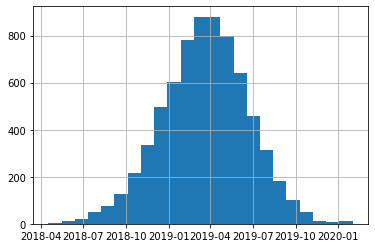

In [23]:
contract['begindate'].hist(bins=23)

Распределение дат начала договора близко к нормальному.

In [24]:
contract[contract['enddate'].notna()]['enddate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: enddate, dtype: int64

А вот даты расторжения договора включают в себя только 4 варианта. Судя по тому, что все они приходятся на первое число, это дата загрузки в бд отчета за предыдущий месяц.

Проверим нет ли в данных строк, где дата завершения предшествует дате начала договора.

In [25]:
contract[contract['begindate']>contract['enddate']]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges


Таких сэмплов нет.

Проверим наличие дубликатов

In [26]:
contract.duplicated().sum()

0

In [27]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [28]:
contract['paperlessbilling'].value_counts()

Yes    4171
No     2872
Name: paperlessbilling, dtype: int64

In [29]:
contract['paymentmethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: paymentmethod, dtype: int64

Неявных дубликатов тоже нет.

## 2.2 Personal

In [30]:
personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Таблица содержит персональные данные клиентов.
1. customerID — ID пользователя;
2. gender — пол;
3. SeniorCitizen — является ли абонент пенсионером;
4. Partner — есть ли у абонента супруг или супруга;
5. Dependents — есть ли у абонента дети.

In [31]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В этой таблице пропусков нет.
Поле seniorcitizen уже переведенно в численый вид, другия поля нужно будет энкодировать дополнительно.

In [32]:
personal.duplicated().sum()

0

In [33]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [34]:
personal['seniorcitizen'].value_counts()

0    5901
1    1142
Name: seniorcitizen, dtype: int64

In [35]:
personal['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

In [36]:
personal['dependents'].value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

Все поля содержать только 2 класса, дубликатов, так же, нет.

## 2.3 Internet

In [37]:
internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Таблица содержит информацию об интернет-услугах.
1. customerID — ID пользователя;
2. InternetService — тип подключения;
3. OnlineSecurity — блокировка опасных сайтов;
4. OnlineBackup — облачное хранилище файлов для резервного копирования данных;
5. DeviceProtection — антивирус;
6. TechSupport — выделенная линия технической поддержки;
7. StreamingTV — стриминговое телевидение;
8. StreamingMovies — каталог фильмов.

In [38]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


строчек в этой таблице меньше, чем в предыдущих. Вероятно, это связано с тем, что остальные абоненты не пользуются этой услугой.

In [39]:
internet.duplicated().sum()

0

In [40]:
internet['internetservice'].value_counts()

Fiber optic    3096
DSL            2421
Name: internetservice, dtype: int64

In [41]:
internet['onlinesecurity'].value_counts()

No     3498
Yes    2019
Name: onlinesecurity, dtype: int64

In [42]:
internet['onlinebackup'].value_counts()

No     3088
Yes    2429
Name: onlinebackup, dtype: int64

In [43]:
internet['deviceprotection'].value_counts()

No     3095
Yes    2422
Name: deviceprotection, dtype: int64

In [44]:
internet['techsupport'].value_counts()

No     3473
Yes    2044
Name: techsupport, dtype: int64

In [45]:
internet['streamingtv'].value_counts()

No     2810
Yes    2707
Name: streamingtv, dtype: int64

In [46]:
internet['streamingmovies'].value_counts()

No     2785
Yes    2732
Name: streamingmovies, dtype: int64

Пропусков и дубликатов нет.

## 2.4 Phone

In [47]:
phone.head()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В этой таблице содержится информация об услугах телефонии.
1. customerID — ID пользователя;
2. MultipleLines — подключение телефона к нескольким линиям одновременно.

In [48]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


как и в случае с интернетом, строк меньше, чем записей об абонентах

In [49]:
phone.duplicated().sum()

0

In [50]:
phone['multiplelines'].value_counts()

No     3390
Yes    2971
Name: multiplelines, dtype: int64

## 2.5 Объединение таблиц

Объединим таблицы по столбцу customerid, но основе таблицы с контрактами.

In [51]:
data = personal.merge(contract, how='left', on='customerid').merge(internet, how='left', on='customerid').merge(phone, how='left', on='customerid')

In [52]:
data.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   seniorcitizen     7043 non-null   int64         
 3   partner           7043 non-null   object        
 4   dependents        7043 non-null   object        
 5   begindate         7043 non-null   datetime64[ns]
 6   enddate           1869 non-null   datetime64[ns]
 7   type              7043 non-null   object        
 8   paperlessbilling  7043 non-null   object        
 9   paymentmethod     7043 non-null   object        
 10  monthlycharges    7043 non-null   float64       
 11  totalcharges      7032 non-null   float64       
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

Выделим из полей с датами целевую переменную. А затем заполним пропуски в поле даты завершения договора первым февраля 2020, т.к. имеющаяся информация по договорам актуальная именно на эту дату.

In [54]:
data['break'] = 0
data['break'].where(data['enddate'].isna(), 1, inplace=True) 
data['enddate'].fillna(pd.to_datetime('2021-02-01', format='%Y-%m-%d %H:%M:%S.%f'), inplace=True)

In [55]:
data['break'].value_counts()

0    5174
1    1869
Name: break, dtype: int64

Выборка дисбалансирована. Действующих договоров в 2.77 раз больше расторгнутых.

вычислим продолжительность контракта для бывших и действующихх клиентов.

In [56]:
data['duration'] = [(data.loc[x]['enddate']-data.loc[x]['begindate']).days for x in range(len(data))]

Проверим есть ли абоненты с пропусками и в интернет-услугах, и в телефонии. Если нет, то это может считаться подтверждением идеи, что пропуски связаны с тем, что услуга просто не используется.

In [57]:
len(data[data['internetservice'].isna() & data['multiplelines'].isna()])

0

Таких строк нет, можно будет заполнить пропуски соответствующим способом.

проверим распределение по целевым классам данных по продолжительности договора.
Будем использовать параметр density, что бы количественное распределение классов не повлияло на наглядность.

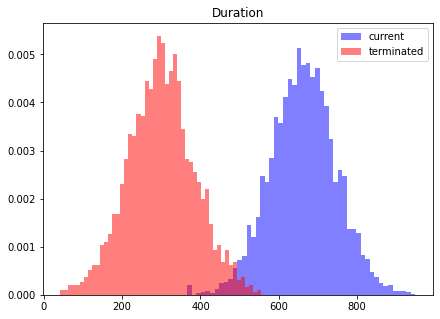

In [58]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(data[data['break']==0]['duration'], bins=50, fc=(0, 0, 1, 0.5), density=True)
ax.hist(data[data['break']==1]['duration'], bins=50, fc=(1, 0, 0, 0.5), density=True)
ax.legend(['current', 'terminated'])
plt.title('Duration', fontsize=12)
plt.show()

Разделение довольно очевидно. Большинство разрывающих договор делают это в первый год использования.

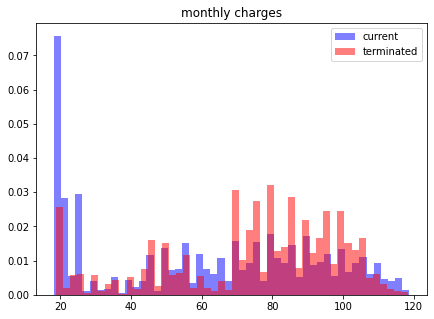

In [59]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(data[data['break']==0]['monthlycharges'], bins=50, fc=(0, 0, 1, 0.5), density=True, label='break')
ax.hist(data[data['break']==1]['monthlycharges'], bins=50, fc=(1, 0, 0, 0.5), density=True, label='unbreak')
ax.legend(['current', 'terminated'])
plt.title('monthly charges', fontsize=12)
plt.show()

Можно отметить, что чаще разрывают договор клиенты с большей ежемесячной стоимостью услуг.

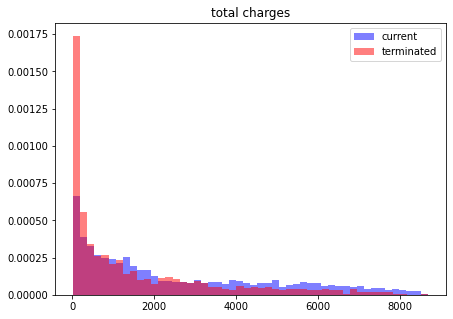

In [60]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.hist(data[data['break']==0]['totalcharges'], bins=50, fc=(0, 0, 1, 0.5), density=True)
ax.hist(data[data['break']==1]['totalcharges'], bins=50, fc=(1, 0, 0, 0.5), density=True)
ax.legend(['current', 'terminated'])
plt.title('total charges', fontsize=12)
plt.show()

График общих затрат по мере увеличения суммы становися более синим, что лгично, т.к. те, кто разрывают контракт раньше не успевают накопить большую сумму затрат.

In [61]:
cols = data.columns.drop(['customerid', 'begindate', 'enddate', 'break', 'duration', 'monthlycharges', 'totalcharges',]) #категориальные фичи для визуализации

Проверим распределение категориальных признаков в классах

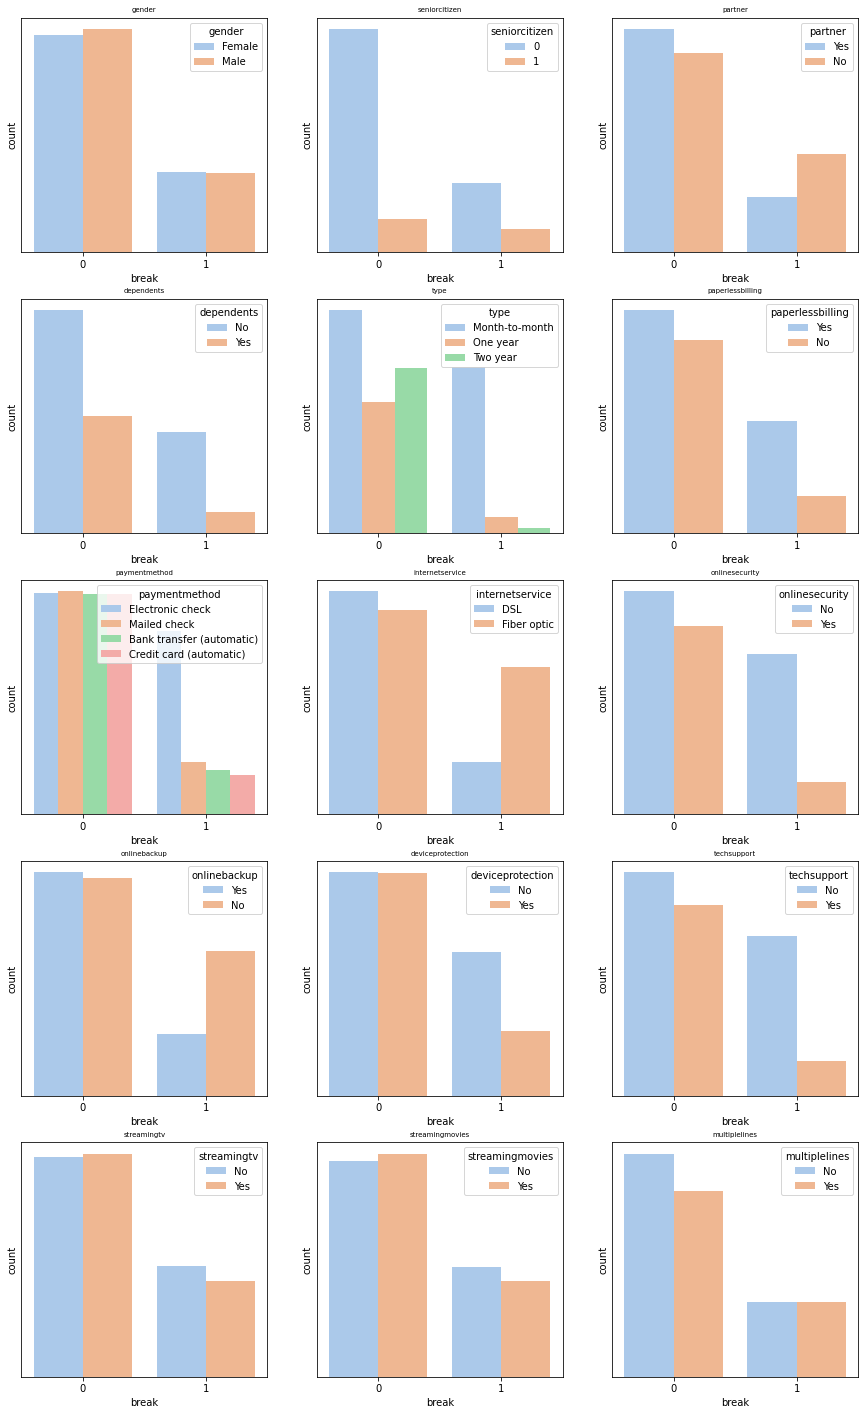

In [62]:
fig = plt.figure(figsize=(15,25))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    sns.countplot(data=data, x='break', hue=cols[i], palette="pastel")
    plt.yticks([])
    plt.title(cols[i], fontsize=7)
plt.show()



Из интересного на мой взгляд:

Наличие партнера. Клиенты, имеющие партнера менее склонны к разрыву контракта. Возможно, это связано с тем, что партнер так же является клиентом, и это просто удобнее. А может в общей надежности/консервативности людей в парах.

Периодичность оплаты. Те кто платит за год-два тоже относятся к действующим клиентам. Но тут причинная связь совсем не очевидна. Вполне вероятно, что так оплатили те, кто после первого года обслуживания на ежемесячной оплате приняли решение остаться. Так же можно объединить год и два в один класс, снижаются они в зависимости от целевой переменной +/- пропорционально, относительно помесячной оплаты.

Способ оплаты. Среди тех, кто прервал договор, подавляющее большинство оплачивало электронно.

Тип подключения. Разорвавшие контракт клиенты чаще пользовались именно оптоволоконным кабелем.

Безопасность. Использование дополнительных услуг (антивирус, блокировка опасных сайтов, выделенная линия технической поддержки, облачное хранилище файлов для резервного копирования данных) характерно для тех, кто задерживается в компании.

interval columns not set, guessing: ['gender', 'seniorcitizen', 'partner', 'dependents', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines', 'break']


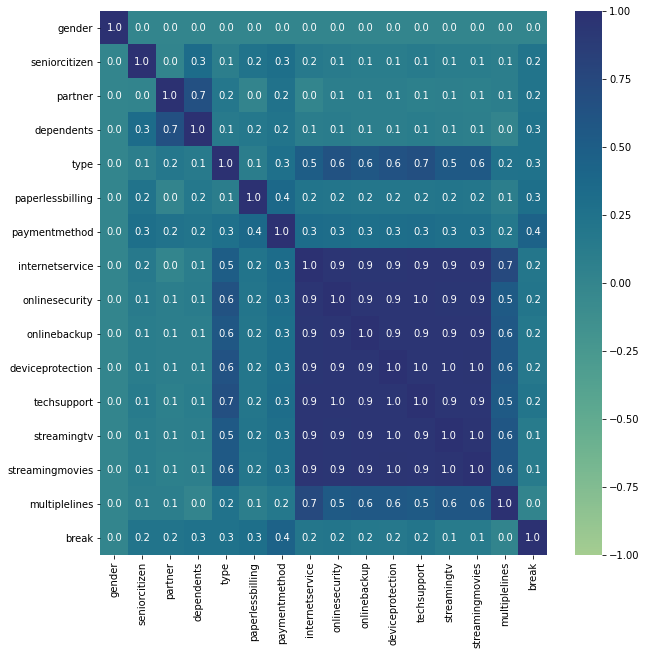

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.heatmap(data.drop(['customerid', 'enddate', 'begindate', 'monthlycharges', 'totalcharges', 'duration'], axis=1)
                     .apply(lambda x : pd.factorize(x)[0]).phik_matrix(), 
                 annot=True, fmt=".1f", cmap="crest", vmin=-1)
plt.show()

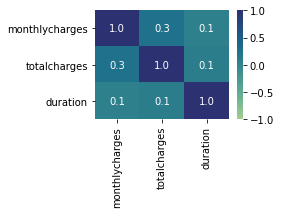

In [64]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax = sns.heatmap(data[['monthlycharges', 'totalcharges', 'duration']]
                     .apply(lambda x : pd.factorize(x)[0]).corr(min_periods=1), 
                 annot=True, fmt=".1f", cmap="crest", vmin=-1)
plt.show()

есть слабая взаимосвязь между наличием партнера и детей, продолжительностью договора и фактом его расторжения.

Отдельно бросается в глаза довольно сильная линейная зависимость в блоке с интернет-услугами. Можно попробовать уменьшить рамерность, кластарезовав этот блок без потери в точности, а, возможно, и увеличить метрику за счет устранения коллинеарности.

## 2.6 Подготовка данных к обучению

заполним пропуски в полях интернет-услуг и телефонии.

In [65]:
[data[c].fillna('disable', inplace=True) for c in internet.columns]
data['multiplelines'].fillna('disable', inplace=True)

In [66]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=RANDOM_STATE) # сразу отделим тестовую выборку, что бы на ней не обучались энкодеры и т.д.

In [67]:
cat_col = data.columns.drop(['customerid', 'begindate', 'enddate', 'monthlycharges', # выделим список категориальных признаков
                             'totalcharges', 'break', 'duration'])

In [68]:
oe = OrdinalEncoder() # и переведем эти признаки в "цифру"
train_data = pd.concat([train_data.drop(cat_col, axis=1), pd.DataFrame(oe.fit_transform(train_data[cat_col]), columns=cat_col)], axis=1)

Использовать OHE пока нецелесообразно. Первыми моделями будут древообразные, которые нормально работают с мультиклассом.

In [69]:
def y_extract(data, y_name, rand, size=0): #выделение из датасета целевого признака и разбиение данных на учебную и валидационную
    target = data[y_name]
    features = data.drop(y_name, axis=1)
    if size>0:
        X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size = size, random_state = rand)
        for d in (X_train, X_valid, y_train, y_valid):
            d.reset_index(drop=True, inplace=True)
        return X_train, X_valid, y_train, y_valid
    else: 
        return features, target

Узалим столбцы, которые, по логике, не должны приниматься во внимание при обучении

In [70]:
train_data = train_data.drop(['customerid', 'begindate', 'enddate'], axis=1).dropna() 

In [71]:
def data_testing(datat, yname, rs, vs=True): # функция для нагладного определения влияния фичей на предикт
    X_train, X_valid, y_train, y_valid = y_extract(datat, yname, rs, size=.25)
    model = DecisionTreeClassifier(random_state=rs)

    model.fit(X_train, y_train)
    predict = model.predict_proba(X_valid)[:,1]
    
    if vs:
        tree_explainer = shap.TreeExplainer(model)
        shap_val = tree_explainer.shap_values(X_valid)
        shap.summary_plot(shap_val[1], X_valid)
        print(roc_auc_score(y_valid, predict))
    return roc_auc_score(y_valid, predict)

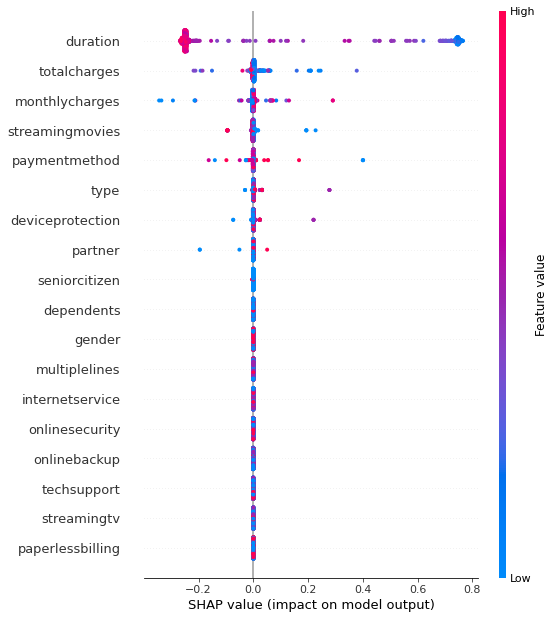

0.9827993219563431


0.9827993219563431

In [72]:
data_testing(train_data, 'break', RANDOM_STATE)

Наибольшее влияние оказывает продолжительность договора. Дальше следует ежемесячная стоимость: чем выше сумма, тем выше вероятность разрыва договора.
Затем общие затраты. Тут ситуация обратная: чем больше сумма, тем ниже вероятность разрыва. Но, как мне кажется, причинно-следственная связь обратная: чем дольше договор продолжается, тем большая сумма копится.

Остальные фичи оказываю заметно меньшее влияние на предсказательную способность.

In [73]:
train_data = train_data.drop('totalcharges', axis=1)

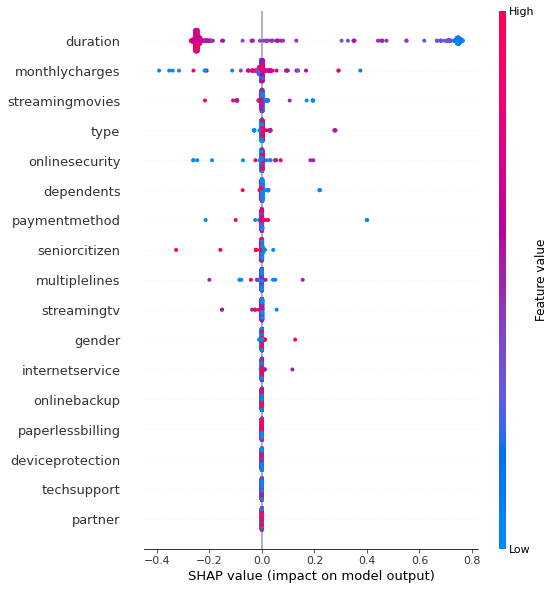

0.9734008257157416


0.9734008257157416

In [74]:
data_testing(train_data, 'break', RANDOM_STATE)

Кластеризуем поля связанные с интернет-услугами.

In [75]:
X = train_data[internet.columns.drop('customerid')]

kmeans = KMeans(n_clusters=3)
X["cluster"] = kmeans.fit_predict(X)

train_data['internet_cluster'] = X["cluster"]
train_data.drop(internet.columns.drop('customerid'), axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


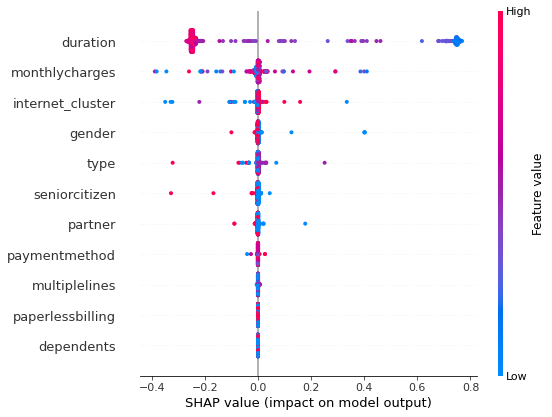

0.9724076789484084


0.9724076789484084

In [76]:
data_testing(train_data, 'break', RANDOM_STATE)

## 2.7 Подготовка тестовых данных

Аналогичным образом сразу подготовим тестовую выборку

In [77]:
test_data = test_data.drop(['customerid', 'begindate', 'enddate','totalcharges'], axis=1).dropna().reset_index(drop=True)####
test_data = pd.concat([test_data.drop(cat_col, axis=1), pd.DataFrame(oe.transform(test_data[cat_col]), columns=cat_col)], axis=1)

In [78]:
X = test_data[internet.columns.drop('customerid')]

X["cluster"] = kmeans.predict(X)

test_data['internet_cluster'] = X["cluster"]
test_data.drop(internet.columns.drop('customerid'), axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
X_test, y_test = y_extract(test_data, 'break', RANDOM_STATE, size=0)

In [80]:
cat_col = train_data.columns.drop(['monthlycharges', 'break'])#['monthlycharges', 'totalcharges', 'break', 'duration'])

# 3. Обучение модели

In [81]:
X, y = y_extract(train_data, 'break', RANDOM_STATE, size=0)

## 3.1 Random Forest

Первой обучим модель случайного леса.

In [82]:
params_rf = {  
    'n_estimators': np.arange(100, 201, 20), 
    'max_depth': np.arange(2, 21, 2),
    'random_state': [RANDOM_STATE], 
    'class_weight': [None, 'balanced']
}


In [83]:
model_rf = RandomForestClassifier()

In [84]:
gs = GridSearchCV(model_rf, params_rf, scoring='roc_auc', cv=5, verbose=1)
gs.fit(X,y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                         'n_estimators': array([100, 120, 140, 160, 180, 200]),
                         'random_state': [130423]},
             scoring='roc_auc', verbose=1)

In [85]:
params_rf = gs.best_params_

In [86]:
gs.cv_results_['mean_test_score'].max()

0.9987130660258032

In [87]:
model_rf = RandomForestClassifier(**params_rf)
model_rf.fit(X, y)

RandomForestClassifier(max_depth=14, random_state=130423)

## 3.2 Boosting

Для модели ГБ применим XGBoost на основе деревьев

In [88]:
params_gb={
    'max_depth': [1],
    'n_estimators': [180],
    'random_state': [130423],
    'scale_pos_weight': [2.77],
    'use_label_encoder': [False],
    'verbosity': [0]}
'''
{  
    'n_estimators': np.arange(50, 201, 10), 
    'max_depth': np.arange(1, 7, 2),
    'scale_pos_weight': [1, 2.77],
    'random_state': [RANDOM_STATE],
    'verbosity': [0],
    'use_label_encoder': [False]
}
'''

"\n{  \n    'n_estimators': np.arange(50, 201, 10), \n    'max_depth': np.arange(1, 7, 2),\n    'scale_pos_weight': [1, 2.77],\n    'random_state': [RANDOM_STATE],\n    'verbosity': [0],\n    'use_label_encoder': [False]\n}\n"

In [89]:
model_gb = XGBClassifier()

In [90]:
gs = GridSearchCV(model_gb, params_gb, scoring='roc_auc', cv=5)
gs.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [91]:
params_gb = gs.best_params_

In [92]:
gs.cv_results_['mean_test_score'].max()

0.9988050889619698

In [93]:
model_gb = XGBClassifier(**params_gb)
model_gb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=130423,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.77, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

## 3.3 NN

И последней моделью попробуем полносвязную нейронную сеть

In [94]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode="fan_in", nonlinearity="sigmoid")

In [95]:
class CustomEarlyStopping(): 
# класс для проверки изменения целевой метрики. 
# Если она долго не меняется, или меняется незначительно, то обучение прерывается
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.metric = None
        self.early_stop = False

    def __call__(self, val_metric):
        if self.metric == None:
            self.metric = val_metric
        elif val_metric - self.metric > self.min_delta:
            self.metric = val_metric
            self.counter = 0
        elif val_metric - self.metric < self.min_delta:
            self.counter += 1
            #print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                #print('INFO: Early stopping')
                self.early_stop = True

In [96]:
class MyNN(): 
    
    def __init__(self, neurons, afunc, reg='', dop=[]):
        self.neurons = neurons
        self.neurons.append(1) # добавим слой на выхо
        self.afunc = afunc # массив с функцией активации
        self.net_layers = []
        self.reg = reg
        self.dop = dop
        self.net = self.construct_net()
        self.net.apply(self.init_weights)
        
        
    def construct_net(self):
        for i in range(1, len(self.neurons) - 1):
            self.net_layers.append(nn.Linear(self.neurons[i-1], self.neurons[i]))
            self.net_layers.append(self.afunc[i-1])
            if self.reg == 'bn': self.net_layers.append(nn.BatchNorm1d(self.neurons[i]))
            if self.reg == 'do': self.net_layers.append(nn.Dropout(dop[i-1]))
        self.net_layers.append(nn.Linear(self.neurons[-2], self.neurons[-1]))
        self.net_layers.append(self.afunc[-1])
        net = nn.Sequential(*self.net_layers)
        return net
    
    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_uniform_(layer.weight, mode="fan_out", nonlinearity="relu")

In [97]:
def learning_curve(scores):
    plt.plot(scores['metr_train'], color = 'red', label = 'Train')
    plt.plot(scores['metr_test'], label = 'Test')
    plt.legend()
    plt.show()

Продолжим преобразовывать данные

In [98]:
ohe = OneHotEncoder(drop='first', handle_unknown='error')
X = pd.concat([X.drop(cat_col, axis=1).reset_index(drop=True), pd.DataFrame(ohe.fit_transform(X[cat_col]).toarray())], axis=1)

In [99]:
scaler = StandardScaler()
scaler.fit(X.to_numpy())
X = scaler.transform(X.to_numpy())

In [100]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(np.array(y))

In [103]:
def new_layer(neur, #архитектура НС
              afunc,  #Массив с функциями активации
              X_t,  #Учебная выборка
              X_v,  #Влидационная выборка
              y_t,  #Учебный таргет
              y_v,  #Валидационный таргет
              in_metr=0,  #текущая метрика для подбора гипепрпараметров
              check = False,  #Флаг для визуализации и мониторинга обучения
              epochs = 5000,  #Максимальное количество эпох
              reg=None,  #Способ регуляризации (bn - батчнорм, do - дропаут)
              dop = 0,  #Массив с % для дропаута по слоям
              metr=0,  #Значение глобальной метрики 
              batch_s = 100): #Размер батча

    n = neur.copy()
    n.append(1) # добавим слой на выход
    net_layers = []
    b_metr = in_metr
    score = []
    opt_epoch = 0
    vis = False

    loss = nn.MSELoss()
    model_nn = MyNN(n, afunc, loss)
    optimizer = torch.optim.Adam(model_nn.net.parameters(), lr=1e-3)
    
    num_epochs = epochs
    batch_size = batch_s
    num_batches = ceil(X_t.shape[0]/batch_size)
    early_stopping = CustomEarlyStopping(patience=200, min_delta=.002) 
    #для проверки процесса обучения оставим 200 эпох и .02  шага изменений
    
    for epch in range(num_epochs):
        early_stopping(b_metr)
        if early_stopping.early_stop:
            break #изменений нет
        model_nn.net.train()
        order = np.random.permutation(X_t.shape[0])
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_t[batch_indexes].detach().clone()
            y_batch = torch.FloatTensor(np.array(y_t[batch_indexes]))
            preds = model_nn.net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch).float()
            loss_value.backward()
            optimizer.step()
      
        if epch % 10 == 0 or epch == num_epochs - 1:
            with torch.no_grad():
                model_nn.net.eval()
                test_preds = model_nn.net.forward(X_v)
                metr_test = roc_auc_score(y_v.detach().numpy(), test_preds.detach().numpy())
                if metr_test > b_metr:
                    b_metr = metr_test
                    opt_epoch = epch
                    if b_metr > metr:
                        vis = True
                if check: # сохранение результатов на учебных данных для кривой
                    train_preds = model_nn.net.forward(X_t).round()
                    metr_train = roc_auc_score(y_t.detach().numpy(), train_preds.detach().numpy())
                    score.append([metr_train, metr_test])
    if vis and check:
        score = pd.DataFrame(score, columns=['metr_train', 'metr_test'])
        learning_curve(score)
        print(n, b_metr)
        print("___________________________")
    return b_metr, opt_epoch

In [104]:
# подбирается количество нейронов в каждом слое НС. Выбираетя самый лучший 
# вариант для каждого слоя, но, в итоге, сохраняется наиболее оптимальный,

in_n = X.shape[1]
net_var=[] #массив для хранения структуры сети
temp_net_var=[]
neurons = 0
nneu=[] #временный массив для хранения структуры сети
nneu.append(in_n)
epochs=0
metr=0

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


for hid_n in np.arange(len(nneu),6): #сеть с 5 скрытыми слоями
    for l in np.arange(len(nneu)-1,hid_n):
        local_metr=0
        for i in np.arange(4, 41, 4): # от 4 до 40 нейронов в слое
            temp_metr=0
            n_neu=nneu.copy()
            n_neu.append(i)
            function = np.full(len(n_neu), nn.ReLU()) #оставим РеЛу для скорости вычисления
            function = np.append(function, nn.Sigmoid()) #Сигма для классификации
            for train, test in kf.split(X, y):
                metr_n, ep = new_layer(n_neu, function, X[train], X[test], y[train], y[test], 
                                       in_metr=0, epochs=10000, metr=metr)
                temp_metr+=metr_n
            temp_metr = temp_metr/5
            if temp_metr > local_metr:
                local_metr = temp_metr
                neurons = i
                temp_net_var = n_neu.copy()
            if temp_metr > metr:
                metr = temp_metr
                epochs = ep
                net_var = n_neu.copy()
        nneu.append(neurons)


In [105]:
print(net_var, epochs, metr)

[718, 40, 16, 12, 28, 4] 280 0.9005159119655957


Лучшей моделью на кросс-валидации с результатов 0,9988 оказалась XGBoost. Проверим её на тестовых данных.

# 4. Тестирование модели

In [106]:
predict = model_gb.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, predict))
print(accuracy_score(y_test, predict.round()))

0.9976190476190476
0.9806927881885292


Confusion matrix, without normalization
[[1237   23]
 [  11  490]]


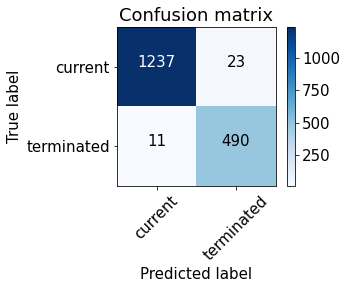

In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, predict.round())
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['current', 'terminated'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

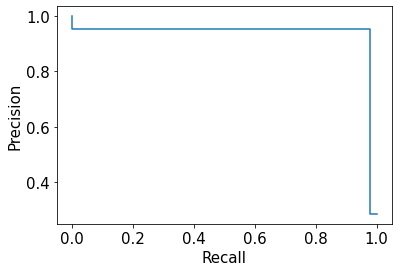

In [108]:
precision, recall, _ = precision_recall_curve(y_test, predict.round())
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

По обоим графикам видно, что модель чаще определяет клиента, как потенциального беглеца, чем это необходимо.

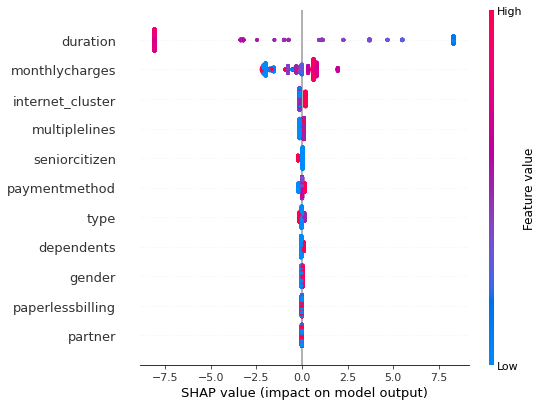

In [109]:
tree_explainer = shap.TreeExplainer(model_gb)
shap_val = tree_explainer.shap_values(X_test)
shap.summary_plot(shap_val, X_test)

Первой по важности, вполне ожидаемо, оказалась продолжительность контракта, а так же объем ежемесячных затрат. По графику выше видно, что чем меньше эта сумма, тем более вероятно, что клиент останется в компании.

# 5. Выводы

Заказчику стоит обратить наиболее пристальное внимание на клиентов в первый год их пользования сервисом, особенно на пользователей интернета. Пользователи на оптоволоконном кабеле чаще других разрывают сотрудничество. Возможно, это связано с более высокой ценой, но стоит лишний раз проверить нет ли проблем с обслуживанием. Оплата электронным чеком тоже характерна для клиентов, разрывающих договор, стоит проконтролировать работу сервиса, возможно где-то есть проблемы. Та же логика может быть в случае меньшей вероятности разрыва договора с клиентами, использующими допуслуги в интернет-обслуживании. Есть вероятность, что облачные сервисы и выделенная линия техподдержки и пр. просто помогают не обращать пристального внимания на проблемы, а не являются показателем высокого уровня обслуживания. Если это не так, то, возможно, стоит добавить их бесплатный демо-период в наиболее вероятный для прекращения договора период (200-400 дней) пользования сервисом.